In [126]:
#import importlib
#import debugsudoku
#importlib.reload(debugsudoku)
#print(debugsudoku.d_model)
%run debugsudoku2.py
print(num_symbols, d_model, depth)
d_model = 9
depth = 3
print(num_symbols, d_model, depth)


9 32 2
9 9 3


In [127]:
print("--- Training with AdamW Optimizer (float32) ---")
torch.set_default_dtype(dtype_float32) # Set default dtype for this block
# 3. Generate training and validation data for AdamW
X_train_oh_adamw, y_train_adamw, X_val_oh_adamw, y_val_adamw, X_train_original_adamw, X_val_original_adamw = generate_data(num_symbols=9, train_frac=0.003, seed=42, dtype=dtype_float64)

# 4. Initialize a new model and loss function
model_adamw, loss_fn_adamw = initialize_model_and_loss(num_symbols, d_model, depth, dtype=dtype_float64)

# 5. Initialize an AdamW optimizer
optimizer_adamw = optim.AdamW(model_adamw.parameters(), lr=0.01,weight_decay=0 )

# 6. Train the model using train_model with AdamW optimizer
adamw_loss_history = train_model(model_adamw, optimizer_adamw, loss_fn_adamw, X_train_oh_adamw, y_train_adamw,
                                 epochs=2500, log_interval=100, optimizer_type='adamw')

--- Training with AdamW Optimizer (float32) ---
Train OH: torch.Size([2177, 9, 9]) Train y: torch.Size([2177, 1])
Val OH:   torch.Size([723583, 9, 9]) Val y: torch.Size([723583, 1])
Epoch    0 | Loss: 0.54783118 | Acc: 0.50987598
Epoch  100 | Loss: 0.01801331 | Acc: 0.98805696
Epoch  200 | Loss: 0.00667922 | Acc: 0.99678457
Epoch  300 | Loss: 0.02948334 | Acc: 1.00000000
Epoch  400 | Loss: 0.00347590 | Acc: 0.99862196
Epoch  500 | Loss: 0.00495624 | Acc: 0.99908130
Epoch  600 | Loss: 0.00313968 | Acc: 1.00000000
Epoch  700 | Loss: 0.00280877 | Acc: 1.00000000
Epoch  800 | Loss: 0.00187123 | Acc: 1.00000000
Epoch  900 | Loss: 0.00193308 | Acc: 1.00000000
Epoch 1000 | Loss: 0.00172970 | Acc: 1.00000000
Epoch 1100 | Loss: 0.00225338 | Acc: 1.00000000
Epoch 1200 | Loss: 0.00149110 | Acc: 1.00000000
Epoch 1300 | Loss: 0.00185698 | Acc: 1.00000000
Epoch 1400 | Loss: 0.00212690 | Acc: 1.00000000
Epoch 1500 | Loss: 0.00152903 | Acc: 1.00000000
Epoch 1600 | Loss: 0.00144531 | Acc: 1.00000000
Ep

In [183]:
loss_fn_lbfgs2 = torch.nn.MSELoss(reduction='sum')

optimizer_lbfgs2 = torch.optim.LBFGS(
    model_adamw.parameters(),
    lr=1.0,
    max_iter=50,
    history_size=100,
    line_search_fn="strong_wolfe",
    tolerance_grad=1e-12,
    tolerance_change=1e-15
)
def closure2():
    optimizer_lbfgs2.zero_grad()
    outputs = model_adamw(X_train_oh_adamw)
    loss = loss_fn_lbfgs2(outputs, y_train_adamw)
    #print("LBFGS internal loss:", loss.item())
    loss.backward()
    return loss

loss = optimizer_lbfgs2.step(closure2)
print("Final LBFGS loss:", loss.item())

for i in range(50):   # 20 refinement steps usually enough
     loss = optimizer_lbfgs2.step(closure2)
     print(f"LBFGS step {i}, loss {loss.item()}")

with torch.no_grad():
    final_loss = loss_fn_lbfgs2(model_adamw(X_train_oh_adamw), y_train_adamw)
print("True final loss:", final_loss.item())

Final LBFGS loss: 0.11879882742145267
LBFGS step 0, loss 0.11871491407185811
LBFGS step 1, loss 0.11843044196243722
LBFGS step 2, loss 0.11805890937719853
LBFGS step 3, loss 0.11771445415199672
LBFGS step 4, loss 0.11719507758236083
LBFGS step 5, loss 0.11684637805738403
LBFGS step 6, loss 0.11638803173553483
LBFGS step 7, loss 0.11579539473522088
LBFGS step 8, loss 0.11513549774608753
LBFGS step 9, loss 0.11479170703535124
LBFGS step 10, loss 0.1142466192012445
LBFGS step 11, loss 0.11384887155338178
LBFGS step 12, loss 0.11358237623852054
LBFGS step 13, loss 0.11309135249534408
LBFGS step 14, loss 0.11236012410658766
LBFGS step 15, loss 0.11232920944860841
LBFGS step 16, loss 0.11173735029154125
LBFGS step 17, loss 0.11103788935378227
LBFGS step 18, loss 0.11020153034822233
LBFGS step 19, loss 0.10970020175617573
LBFGS step 20, loss 0.1096335636866815
LBFGS step 21, loss 0.1084652984386809
LBFGS step 22, loss 0.1084428591058898
LBFGS step 23, loss 0.10725964978656063
LBFGS step 24, l

In [186]:
total_params = sum(p.numel() for p in model_adamw.parameters())
print("Total parameters:", total_params)

trainable_params = sum(p.numel() for p in model_adamw.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)

total_norm = 0.0
for p in model_adamw.parameters():
    if p.grad is not None:
        total_norm += p.grad.norm().item() ** 2
print("grad norm:", total_norm ** 0.5)

Total parameters: 1009
Trainable parameters: 1009
grad norm: 17.463593061559784


In [188]:
#7. Evaluate the AdamW-trained model on the validation set
print("\n--- Evaluation for AdamW Model (float32) ---")
evaluate_model(model_adamw, loss_fn_adamw, X_val_oh_adamw, y_val_adamw, X_val_original_adamw, data_name="Validation (AdamW, float32)")



--- Evaluation for AdamW Model (float32) ---
Validation (AdamW, float32) results | Loss: 2989.2166 | Acc: 0.9963

Analyzing misclassified Validation (AdamW, float32) examples (2703 total):
  Input: [2, 2, 2, 3, 8, 2, 8, 9, 2], Predicted: 2.4314, Actual: 0
  Input: [7, 4, 2, 7, 4, 7, 2, 7, 4], Predicted: 7.6884, Actual: 0
  Input: [5, 7, 3, 7, 5, 7, 5, 2, 7], Predicted: 3.6974, Actual: 0
  Input: [7, 2, 7, 3, 3, 7, 7, 7, 3], Predicted: 2.0056, Actual: 0
  Input: [7, 1, 2, 7, 6, 2, 7, 2, 7], Predicted: 7.2387, Actual: 0


(2989.2165899402153, 0.9962644230171245)

In [ ]:
t1 = X_val_oh_adamw[0:1]
t2 = y_val_adamw [0:1]
t3 = X_val_original_adamw [0:1]
print(t1.shape)
print(t1)
print(t2)
evaluate_model(model_adamw, loss_fn_adamw, t1, t2, t3, data_name="Validation small (AdamW)")

torch.Size([1, 9, 9])
tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.]]], dtype=torch.float64)
tensor([[0.]], dtype=torch.float64)
tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.]]], dtype=torch.float64)
Linear(in_features=9, out_features=9, bias=False)


In [177]:
# 5. Initialize an AdamW optimizer
optimizer_adamw = optim.AdamW(model_adamw.parameters(), lr=0.001,weight_decay=0 )

adamw_loss_history = train_model(model_adamw, optimizer_adamw, loss_fn_adamw, X_train_oh_adamw, y_train_adamw,
                                 epochs=5, log_interval=100, optimizer_type='adamw')

Epoch    0 | Loss: 0.11691343 | Acc: 1.00000000


In [85]:
print("\n--- Training with Custom Optimizer (Gradient Normalization, float32) ---")
torch.set_default_dtype(dtype_float64) # Set default dtype for this block
# 13. Generate new training and validation data for Custom Optimizer
X_train_oh_custom, y_train_custom, X_val_oh_custom, y_val_custom, X_train_original_custom, X_val_original_custom = generate_data(num_symbols=9, train_frac=0.0003, seed=44, dtype=dtype_float64)

# 14. Initialize yet another new model and loss function
model_custom, loss_fn_custom = initialize_model_and_loss(num_symbols, d_model, depth, dtype=dtype_float64)

# 15. Train the model using train_model with custom update rule
custom_loss_history = train_model(model_custom, None, loss_fn_custom, X_train_oh_custom, y_train_custom,
                                  epochs=5000, optimizer_type='custom', custom_update_fn=custom_gradient_update, log_interval=100)

# 16. Evaluate the custom-optimizer-trained model on the validation set
#print("\n--- Evaluation for Custom Optimizer Model (float32) ---")
#evaluate_model(model_custom, loss_fn_custom, X_val_oh_custom, y_val_custom, X_val_original_custom, data_name="Validation (Custom, float32)")


--- Training with Custom Optimizer (Gradient Normalization, float32) ---
Train OH: torch.Size([217, 9, 9]) Train y: torch.Size([217, 1])
Val OH:   torch.Size([725543, 9, 9]) Val y: torch.Size([725543, 1])
Epoch    0 | Loss: 0.63671528 | Acc: 0.49308756
Epoch  100 | Loss: 5.05694330 | Acc: 0.34562212
Epoch  200 | Loss: 1.50433650 | Acc: 0.47926268
Epoch  300 | Loss: 0.75802980 | Acc: 0.53917050
Epoch  400 | Loss: 0.09604073 | Acc: 0.88940090
Epoch  500 | Loss: 0.15106786 | Acc: 0.99078339
Epoch  600 | Loss: 4.53107003 | Acc: 0.49308756
Epoch  700 | Loss: 0.04766644 | Acc: 0.94009215
Epoch  800 | Loss: 0.02823112 | Acc: 0.97695851
Epoch  900 | Loss: 0.03085156 | Acc: 0.96313363
Epoch 1000 | Loss: 6.33871297 | Acc: 0.50691247
Epoch 1100 | Loss: 0.18248434 | Acc: 0.85714287
Epoch 1200 | Loss: 0.09164618 | Acc: 1.00000000
Epoch 1300 | Loss: 0.01938266 | Acc: 0.98617512
Epoch 1400 | Loss: 0.01619292 | Acc: 0.99078339
Epoch 1500 | Loss: 0.02255813 | Acc: 0.99539173
Epoch 1600 | Loss: 0.01635

In [86]:
print("\n--- Evaluation for Custom Optimizer Model (float32) ---")
evaluate_model(model_custom, loss_fn_custom, X_val_oh_custom, y_val_custom, X_val_original_custom, data_name="Validation (Custom, float32)")


--- Evaluation for Custom Optimizer Model (float32) ---
Validation (Custom, float32) results | Loss: 0.2836 | Acc: 0.9158

Analyzing misclassified Validation (Custom, float32) examples (61061 total):
  Input: [7, 9, 2, 7, 7, 3, 2, 1, 7], Predicted: 3.1260, Actual: 0
  Input: [5, 8, 9, 2, 3, 9, 4, 4, 7], Predicted: 0.8432, Actual: 0
  Input: [5, 3, 3, 9, 3, 9, 1, 7, 3], Predicted: 0.5824, Actual: 0
  Input: [8, 6, 4, 5, 7, 6, 9, 1, 3], Predicted: 0.5608, Actual: 0
  Input: [5, 8, 8, 4, 7, 9, 2, 3, 6], Predicted: 0.5822, Actual: 0


(0.2836465683535916, 0.9158409632509721)

In [87]:
custom_loss_history = train_model(model_custom, None, loss_fn_custom, X_train_oh_custom, y_train_custom,
                                  epochs=1000, optimizer_type='custom', custom_update_fn=custom_gradient_update, log_interval=100)

Epoch    0 | Loss: 0.00065442 | Acc: 1.00000000
Epoch  100 | Loss: 0.00028144 | Acc: 1.00000000
Epoch  200 | Loss: 0.00026091 | Acc: 1.00000000
Epoch  300 | Loss: 0.00022900 | Acc: 1.00000000
Epoch  400 | Loss: 0.00020056 | Acc: 1.00000000
Epoch  500 | Loss: 0.02089223 | Acc: 1.00000000
Epoch  600 | Loss: 0.00776537 | Acc: 1.00000000
Epoch  700 | Loss: 0.00016015 | Acc: 1.00000000
Epoch  800 | Loss: 0.00061865 | Acc: 1.00000000
Epoch  900 | Loss: 0.00010605 | Acc: 1.00000000


In [ ]:
print("\n--- Training with LBFGS Optimizer (float64) ---")
torch.set_default_dtype(dtype_float64) # Set default dtype for this block
# 8. Generate new training and validation data for LBFGS
X_train_oh_lbfgs, y_train_lbfgs, X_val_oh_lbfgs, y_val_lbfgs, X_train_original_lbfgs, X_val_original_lbfgs = generate_data(num_symbols=9, train_frac=0.0003, seed=43, dtype=dtype_float64)

# 9. Initialize another new model and loss function
model_lbfgs, loss_fn_lbfgs = initialize_model_and_loss(num_symbols, d_model, depth, dtype=dtype_float64)

# 10. Initialize an LBFGS optimizer
optimizer_lbfgs = torch.optim.LBFGS(model_lbfgs.parameters(), lr=1.0, max_iter=20, history_size=100, line_search_fn="strong_wolfe")

# 11. Train the model using train_model with LBFGS optimizer
lbfgs_loss_history = train_model(model_lbfgs, optimizer_lbfgs, loss_fn_lbfgs, X_train_oh_lbfgs, y_train_lbfgs,
                                 epochs=400, optimizer_type='lbfgs', log_interval=100) # LBFGS steps are not epochs, usually fewer steps

# # 12. Evaluate the LBFGS-trained model on the validation set
# print("\n--- Evaluation for LBFGS Model (float64) ---")
# evaluate_model(model_lbfgs, loss_fn_lbfgs, X_val_oh_lbfgs, y_val_lbfgs, X_val_original_lbfgs, data_name="Validation (LBFGS, float64)")




--- Training with LBFGS Optimizer (float64) ---
Train OH: torch.Size([217, 9, 9]) Train y: torch.Size([217, 1])
Val OH:   torch.Size([725543, 9, 9]) Val y: torch.Size([725543, 1])
Epoch    0 | Loss: 0.25696788 | Acc: 0.82949311
Epoch  100 | Loss: 0.00000012 | Acc: 1.00000000
Epoch  200 | Loss: 0.00000012 | Acc: 1.00000000
Epoch  300 | Loss: 0.00000012 | Acc: 1.00000000


In [59]:
# 11. Train the model using train_model with LBFGS optimizer
lbfgs_loss_history = train_model(model_lbfgs, optimizer_lbfgs, loss_fn_lbfgs, X_train_oh_lbfgs, y_train_lbfgs,
                                 epochs=400, optimizer_type='lbfgs', log_interval=100) # LBFGS steps are not epochs, usually fewer steps

Epoch    0 | Loss: 0.00264471 | Acc: 0.99724394
Epoch  100 | Loss: 0.00264471 | Acc: 0.99724394
Epoch  200 | Loss: 0.00264471 | Acc: 0.99724394
Epoch  300 | Loss: 0.00264471 | Acc: 0.99724394


In [52]:
print(lbfgs_loss_history[-1])

0.003688274648929497


In [187]:
print(model_adamw)

SymbolicLogicEngine(
  (layers): ModuleList(
    (0-2): 3 x PLTBlock(
      (Wq): Linear(in_features=9, out_features=9, bias=False)
      (Wk): Linear(in_features=9, out_features=9, bias=False)
      (Wv): Linear(in_features=9, out_features=9, bias=False)
      (proj): Linear(in_features=9, out_features=9, bias=True)
    )
  )
  (readout): Linear(in_features=9, out_features=1, bias=True)
)


In [30]:
from torchinfo import summary
summary(model_adamw, input_size=(1,9,9))

from torchviz import make_dot

x = torch.randn(1, 9, 9)
y = model_adamw(x.float())
dot = make_dot(y, params=dict(model_adamw.named_parameters()))
dot.render("model_adamw_graph", format="png")
dot.view()  # opens it directly

'model_adamw_graph.pdf'

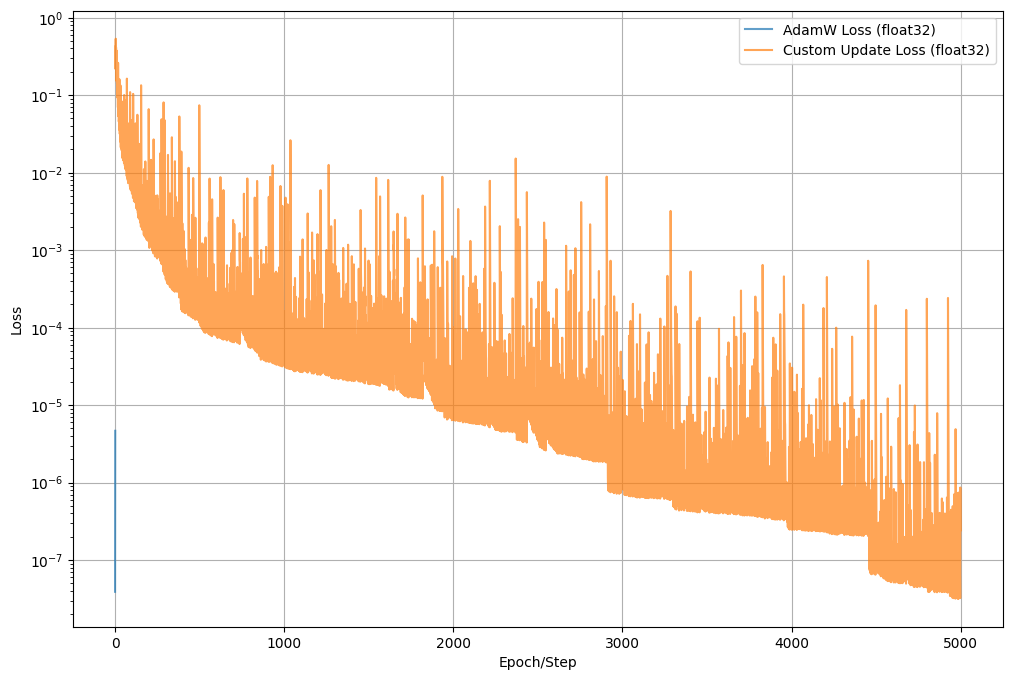

In [31]:
# --- Visualize Training History ---
plt.figure(figsize=(12, 8))
plt.plot(adamw_loss_history, label='AdamW Loss (float32)', alpha=0.7)
# plt.plot(lbfgs_loss_history, label='LBFGS Loss (float64)', alpha=0.7)
plt.plot(custom_loss_history, label='Custom Update Loss (float32)', alpha=0.7)
# plt.plot(small_data_loss_history, label='AdamW (5 Symbols, float32) Loss', alpha=0.7, linestyle='--')
plt.xlabel('Epoch/Step')
plt.ylabel('Loss')
#plt.title('Training Loss History for Different Optimizers and Data Parameters')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for better visualization of different convergence speeds
plt.show()